# AS-II

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
import numpy as np

class FCN(nn.Module):
    def __init__(self, N_INPUT = 2, hidden_layers = [4], N_OUTPUT = 1, activation='Tanh', initialization='Xavier'):
        super().__init__()

        self.activation_functions = nn.ModuleDict([
            ["Tanh", nn.Tanh()],
            ["ReLU", nn.ReLU()],
            ["LeakyReLU", nn.LeakyReLU()],
            ["Sigmoid", nn.Sigmoid()],
            ["Softmax", nn.Softmax(dim=-1)],
        ])

        if activation not in self.activation_functions:
            raise ValueError("Unsupported activation function")

        self.activation = self.activation_functions[activation]

        self.fch = nn.ModuleList([
            nn.Sequential(
                nn.Linear(N_INPUT if i == 0 else hidden_size, hidden_size),
                self.activation
            ) for i, hidden_size in enumerate(hidden_layers[:])    # ) for i, hidden_size in enumerate(hidden_layers[1:])
        ])

        self.fco = nn.Linear(hidden_layers[-1], N_OUTPUT)

        self.initialize_parameters(initialization)

    def forward(self, x):
        #x = self.activation(self.fci(x))
        for layer in self.fch:
            x = self.activation(layer(x))
        x = self.fco(x)
        return x

    def initialize_parameters(self, initialization):
        
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if initialization == 'Uniform':
                    init.uniform_(module.weight.data, -0.1, 0.1)
                    init.zeros_(module.bias.data)
                elif initialization == 'Normal':
                    init.normal_(module.weight.data, mean=0, std=0.01)
                    init.zeros_(module.bias.data)
                elif initialization == 'Xavier':
                    init.xavier_uniform_(module.weight.data)
                    init.zeros_(module.bias.data)
                elif initialization == 'He':
                    init.kaiming_uniform_(module.weight.data, mode='fan_in', nonlinearity='relu')
                    init.zeros_(module.bias.data)
                elif initialization == 'Orthogonal':
                    init.orthogonal_(module.weight.data)
                    init.zeros_(module.bias.data)
                elif initialization == 'Kaiming':
                    init.kaiming_uniform_(module.weight.data, mode='fan_in', nonlinearity='leaky_relu')
                    init.zeros_(module.bias.data)
                else:
                    raise ValueError("Unsupported initialization type")
    
    def plot_weights(self, fig_size = (10,5), font_size = 8):
        
        self.fig_size = fig_size
        self.font_size = font_size
        
        weights_biases_dict = self.state_dict()
        
        # Definition of columns, rows and subplots
        num_subplots = len(weights_biases_dict)
        num_cols = 2
        num_rows = (num_subplots + num_cols - 1) // num_cols  
        
        # For colorbar (collect minimum and maximum values across all tensors)
        all_values = np.concatenate([tensor.flatten() for tensor in weights_biases_dict.values()])
        min_val = round(all_values.min(), 2)
        max_val = round(all_values.max(), 2)
        
        # Create subplots
        fig, axs = plt.subplots(num_rows, num_cols, figsize = self.fig_size)
        
        # Plot images and add values in each subplot
        for i, (key, tensor) in enumerate(weights_biases_dict.items()):
            row = i // num_cols
            col = i % num_cols
            ax = axs[row, col]
            if 'weight' in key:
                im = ax.imshow(tensor, cmap='viridis',vmin=min_val, vmax=max_val, interpolation='none')
                ax.set_title(f'{key}', fontsize = self.font_size)
            elif 'bias' in key:
                im = ax.imshow(tensor.unsqueeze(0), cmap='viridis', vmin=min_val, vmax=max_val, interpolation='none')
                ax.set_title(f'{key}', fontsize = self.font_size)
            #ax.axis('off')
            
            # If the data is 1D (possibly biases), reshape them to (1, len(data))
            if len(tensor.shape) == 1:
                tensor = tensor.reshape(1, -1)

            # Add xticks and yticks
            ax.set_xticks(np.arange(0, tensor.shape[1] , step=1))  
            ax.tick_params(axis='x', labelsize = self.font_size)
            ax.set_yticks(np.arange(0, tensor.shape[0] , step=1))
            ax.tick_params(axis='y', labelsize = self.font_size)

           
            # Add values in the middle of the cell
            for y in range(tensor.shape[0]):
                for x in range(tensor.shape[1]):
                    value = tensor[y, x]
                    ax.text(x, y, f'{value:.2f}', fontsize = self.font_size, color='white', ha='center', va='center')
            
         # Hide extra subplots
        for i in range(num_subplots, num_rows * num_cols):
            axs.flatten()[i].axis('off')
            
        # Add a title to the figure
        plt.suptitle('Weights and Biases of the Neural Network', fontsize = self.font_size)
        
        # Add a colorbar
            # Set custom ticks and intervals
        tick_interval = 0.2
        ticks = np.arange(min_val, max_val, step=tick_interval)

        cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.01])  # [left, bottom, width, height]
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks = ticks)
        cbar.ax.tick_params(labelsize = self.font_size)
        
        cbar.set_label('Range of Weights and Biases', fontsize= self.font_size) 
        
        # Show the plots
        plt.show()

class FCN_extended(FCN):
    def __init__(self, N_INPUT, hidden_layers, N_OUTPUT, activation='Tanh', initialization='Xavier', original_model_path=None):
        super().__init__(N_INPUT, hidden_layers, N_OUTPUT, activation, initialization)

        #self.initialize_parameters(initialization)
        
        self.original_model_path = original_model_path
        self.original_state_dict = self.load_original_state_dict()

        self.extend_layers_neurons()
        
    def extend_layers_neurons(self):
        #current_model.initialize_parameters(initialization)  # Initialize current model first
        for name, param in self.named_parameters():
            
            if name in self.original_state_dict:                
                original_param = self.original_state_dict[name]
                
                if param.shape == original_param.shape:                    
                    param.data.copy_(original_param)   
                    
                else:
                    
                    if "weight" in name: 
                        if param.shape != original_param.shape:  
                            # Copy matching portion of old weights                     
                            param.data[:original_param.size(0), :original_param.size(1)].copy_(original_param)
                        
                        elif param.size(0) != original_param.size(0): 
                            # Copy matching portion of old weights                           
                            param.data[:original_param.size(0), :].copy_(original_param)                           
                        
                        elif param.size(0) != original_param.size(0) and "fc0" in name:                            
                            param.data[0,:original_param.size(1)].copy_(original_param[0]) 
               
                    if "bias" in name: 
                        if param.size(0) != original_param.size(0):  
                            # Copy matching portion of old weights
                            param.data[:original_param.size(0)].copy_(original_param)
                        else:
                            param.data.copy_(original_param)     
    
    def load_original_state_dict(self):
        if self.original_model_path is None:
            raise ValueError("Path to the original model checkpoint is not provided.")

        if not os.path.exists(self.original_model_path):
            raise FileNotFoundError(f"Provided path '{self.original_model_path}' does not exist.")

        if not os.path.isfile(self.original_model_path):
            raise ValueError(f"Provided path '{self.original_model_path}' is not a file.")

        _, ext = os.path.splitext(self.original_model_path)
        if ext not in ['.pt', '.pth']:
            raise ValueError("Provided file is not a valid checkpoint file.")
        
        # Load weights and biases from original_model
        return torch.load(self.original_model_path)['model_state_dict']

class TrainModel:
    def __init__(self, model, num_epochs, save_interval, loss_threshold=None):
        self.model = model
        self.num_epochs = num_epochs
        self.save_interval = save_interval
        self.loss_threshold = loss_threshold
        self.train()
        
    def train(self):
        optimizer = optim.Adam(self.model.parameters())
        criterion = nn.MSELoss()

        for epoch in range(1, self.num_epochs + 1):
            # Train the model
            optimizer.zero_grad()
            # Forward pass
            outputs = self.model(torch.randn(10, original_input_size))
            # Compute loss
            loss = criterion(outputs, torch.randn(10, original_output_size))
            # Backward pass
            loss.backward()
            optimizer.step()

            # Save model checkpoint
            if epoch % self.save_interval == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss
                }, f"original_model_{epoch}.pt")

            # Check loss threshold
            if self.loss_threshold is not None and loss.item() < self.loss_threshold:
                print(f"Loss threshold reached at epoch {epoch}. Stopping training.")
                break


In [2]:
# Usage example
original_input_size = 2
original_hidden_layers = [4]
original_output_size = 1
original_model = FCN(original_input_size, original_hidden_layers, original_output_size, activation='Tanh', initialization='Xavier')

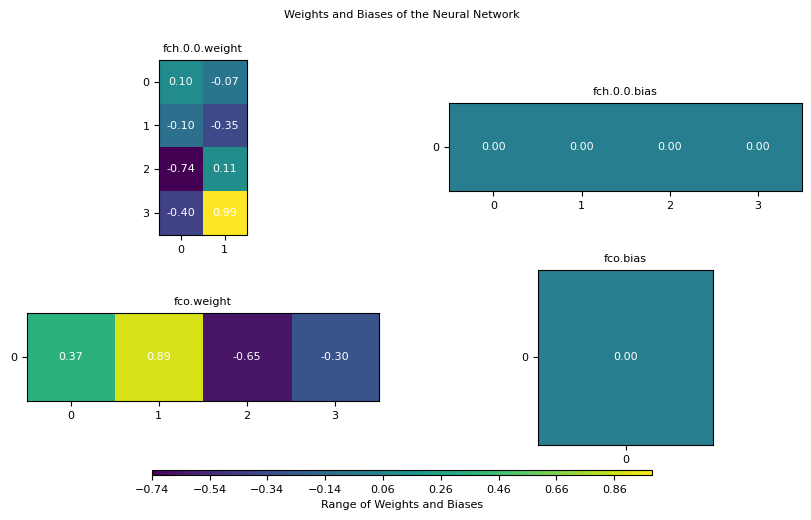

In [3]:
original_model.plot_weights(fig_size = (10,5), font_size = 8)

In [4]:
# Train original model
train_model = TrainModel(original_model, num_epochs=1000, save_interval=100, loss_threshold=0.01)

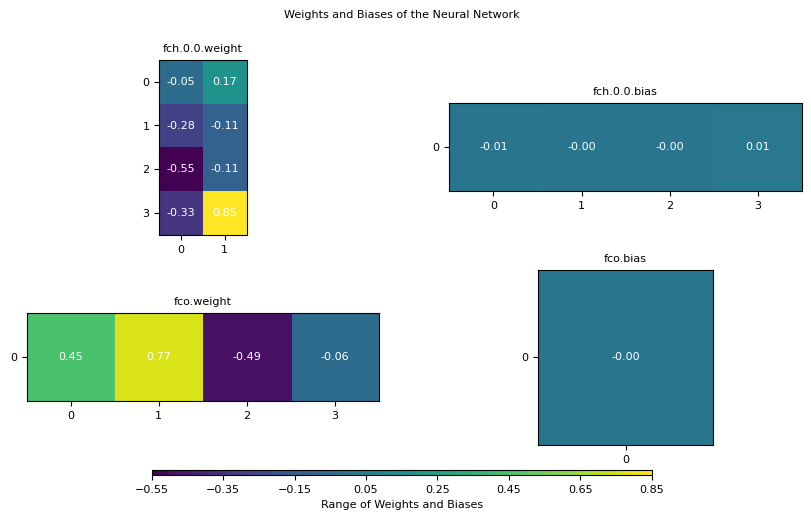

In [5]:
original_model.plot_weights(fig_size = (10,5), font_size = 8)

In [6]:
# Create extended model
extended_input_size = 2
extended_hidden_layers = [4,4]
extended_output_size = 1
extended_model = FCN_extended(extended_input_size, extended_hidden_layers, extended_output_size, activation='Tanh', initialization='Xavier', original_model_path='original_model_1000.pt')

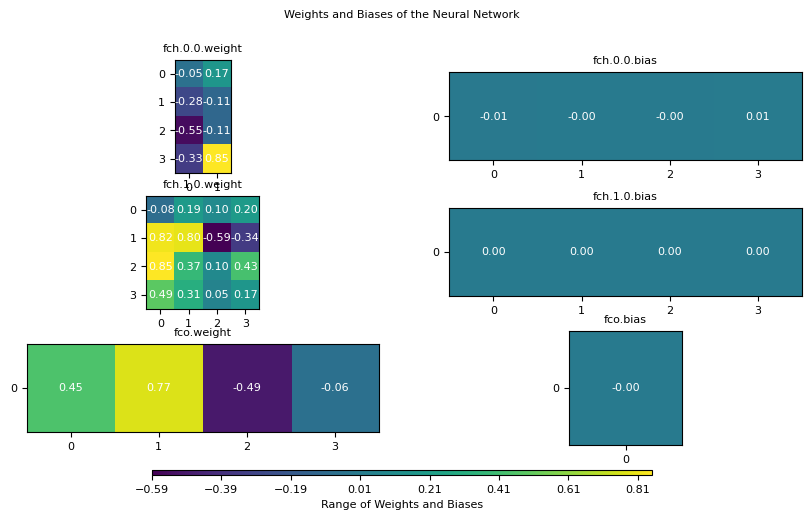

In [7]:
extended_model.plot_weights(fig_size = (10,5), font_size = 8)

In [8]:
# Train original model
train_extended_model = TrainModel(extended_model, num_epochs=1000, save_interval=100, loss_threshold=0.01)

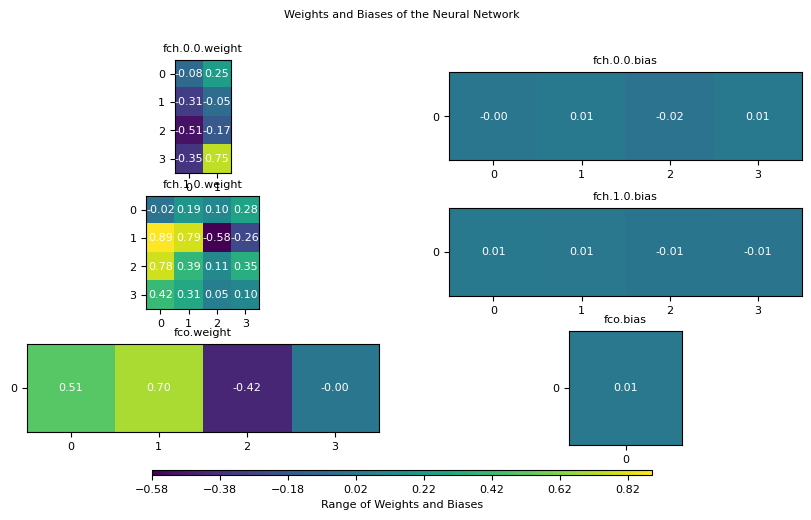

In [9]:
extended_model.plot_weights(fig_size= (10,5), font_size = 8)

In [10]:
# Create extended model
extended1_input_size = 2
extended1_hidden_layers = [8,8]
extended1_output_size = 1
extended1_model = FCN_extended(extended1_input_size, extended1_hidden_layers, extended1_output_size, activation='Tanh', initialization='Xavier', original_model_path='original_model_1000.pt')

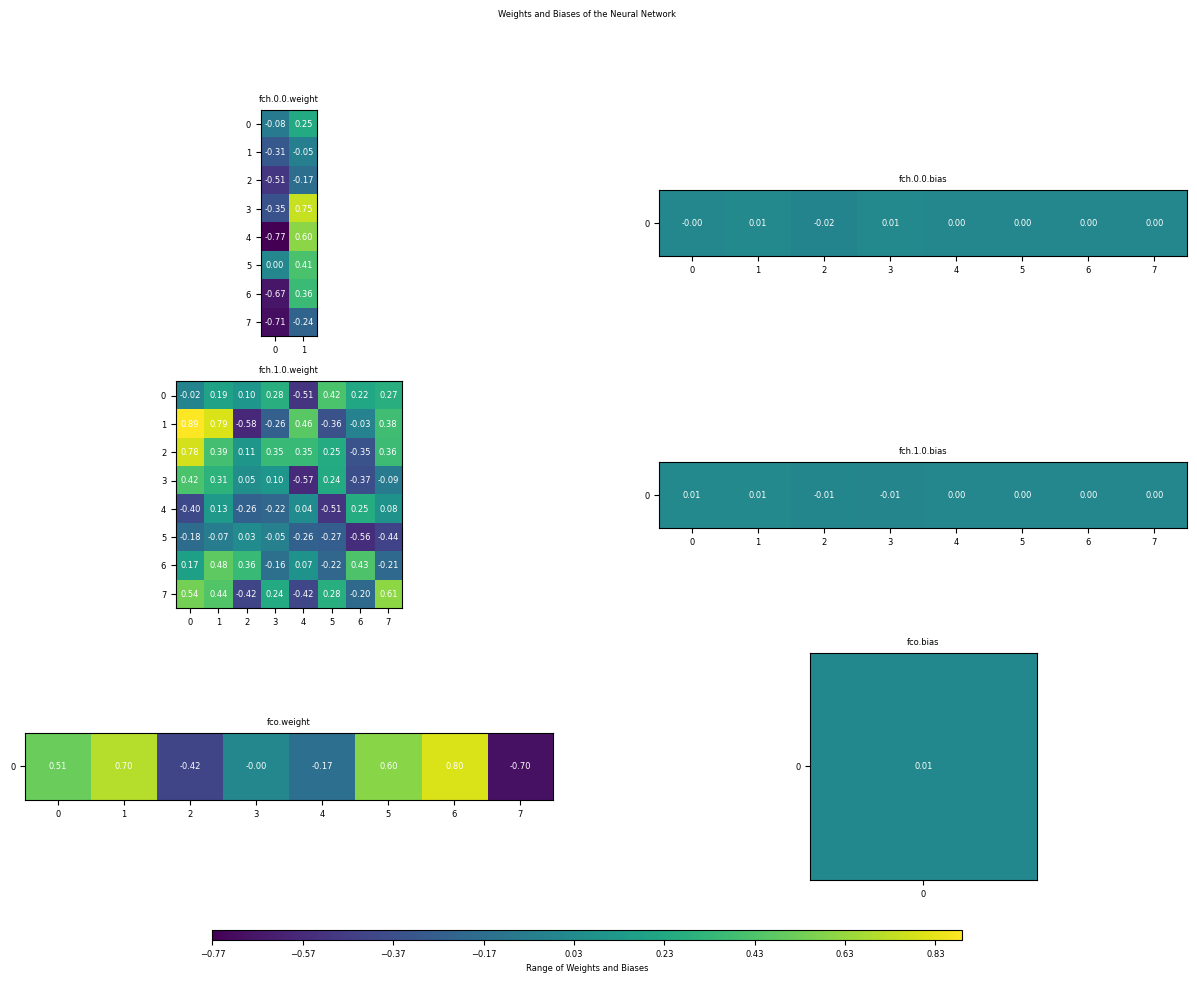

In [11]:
extended1_model.plot_weights(fig_size= (15,10), font_size = 6)

In [12]:
# Train original model
train_extended1_model = TrainModel(extended1_model, num_epochs=1000, save_interval=100, loss_threshold=0.01)

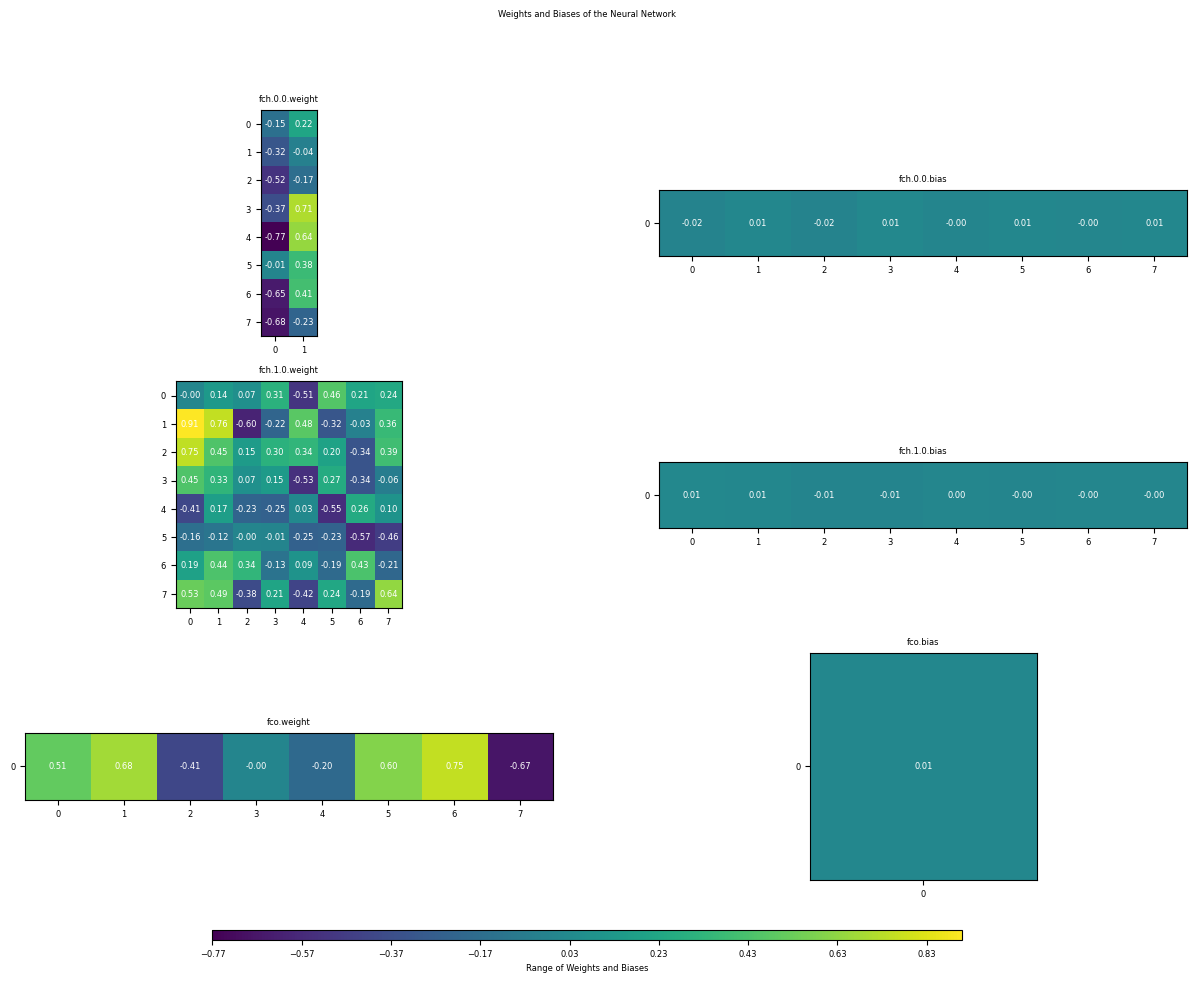

In [13]:
extended1_model.plot_weights(fig_size= (15,10), font_size = 6)

In [14]:
# Create extended model
extended2_input_size = 2
extended2_hidden_layers = [16,16,16,16]
extended2_output_size = 1
extended2_model = FCN_extended(extended2_input_size, extended2_hidden_layers, extended2_output_size, activation='Tanh', initialization='Xavier', original_model_path='original_model_1000.pt')

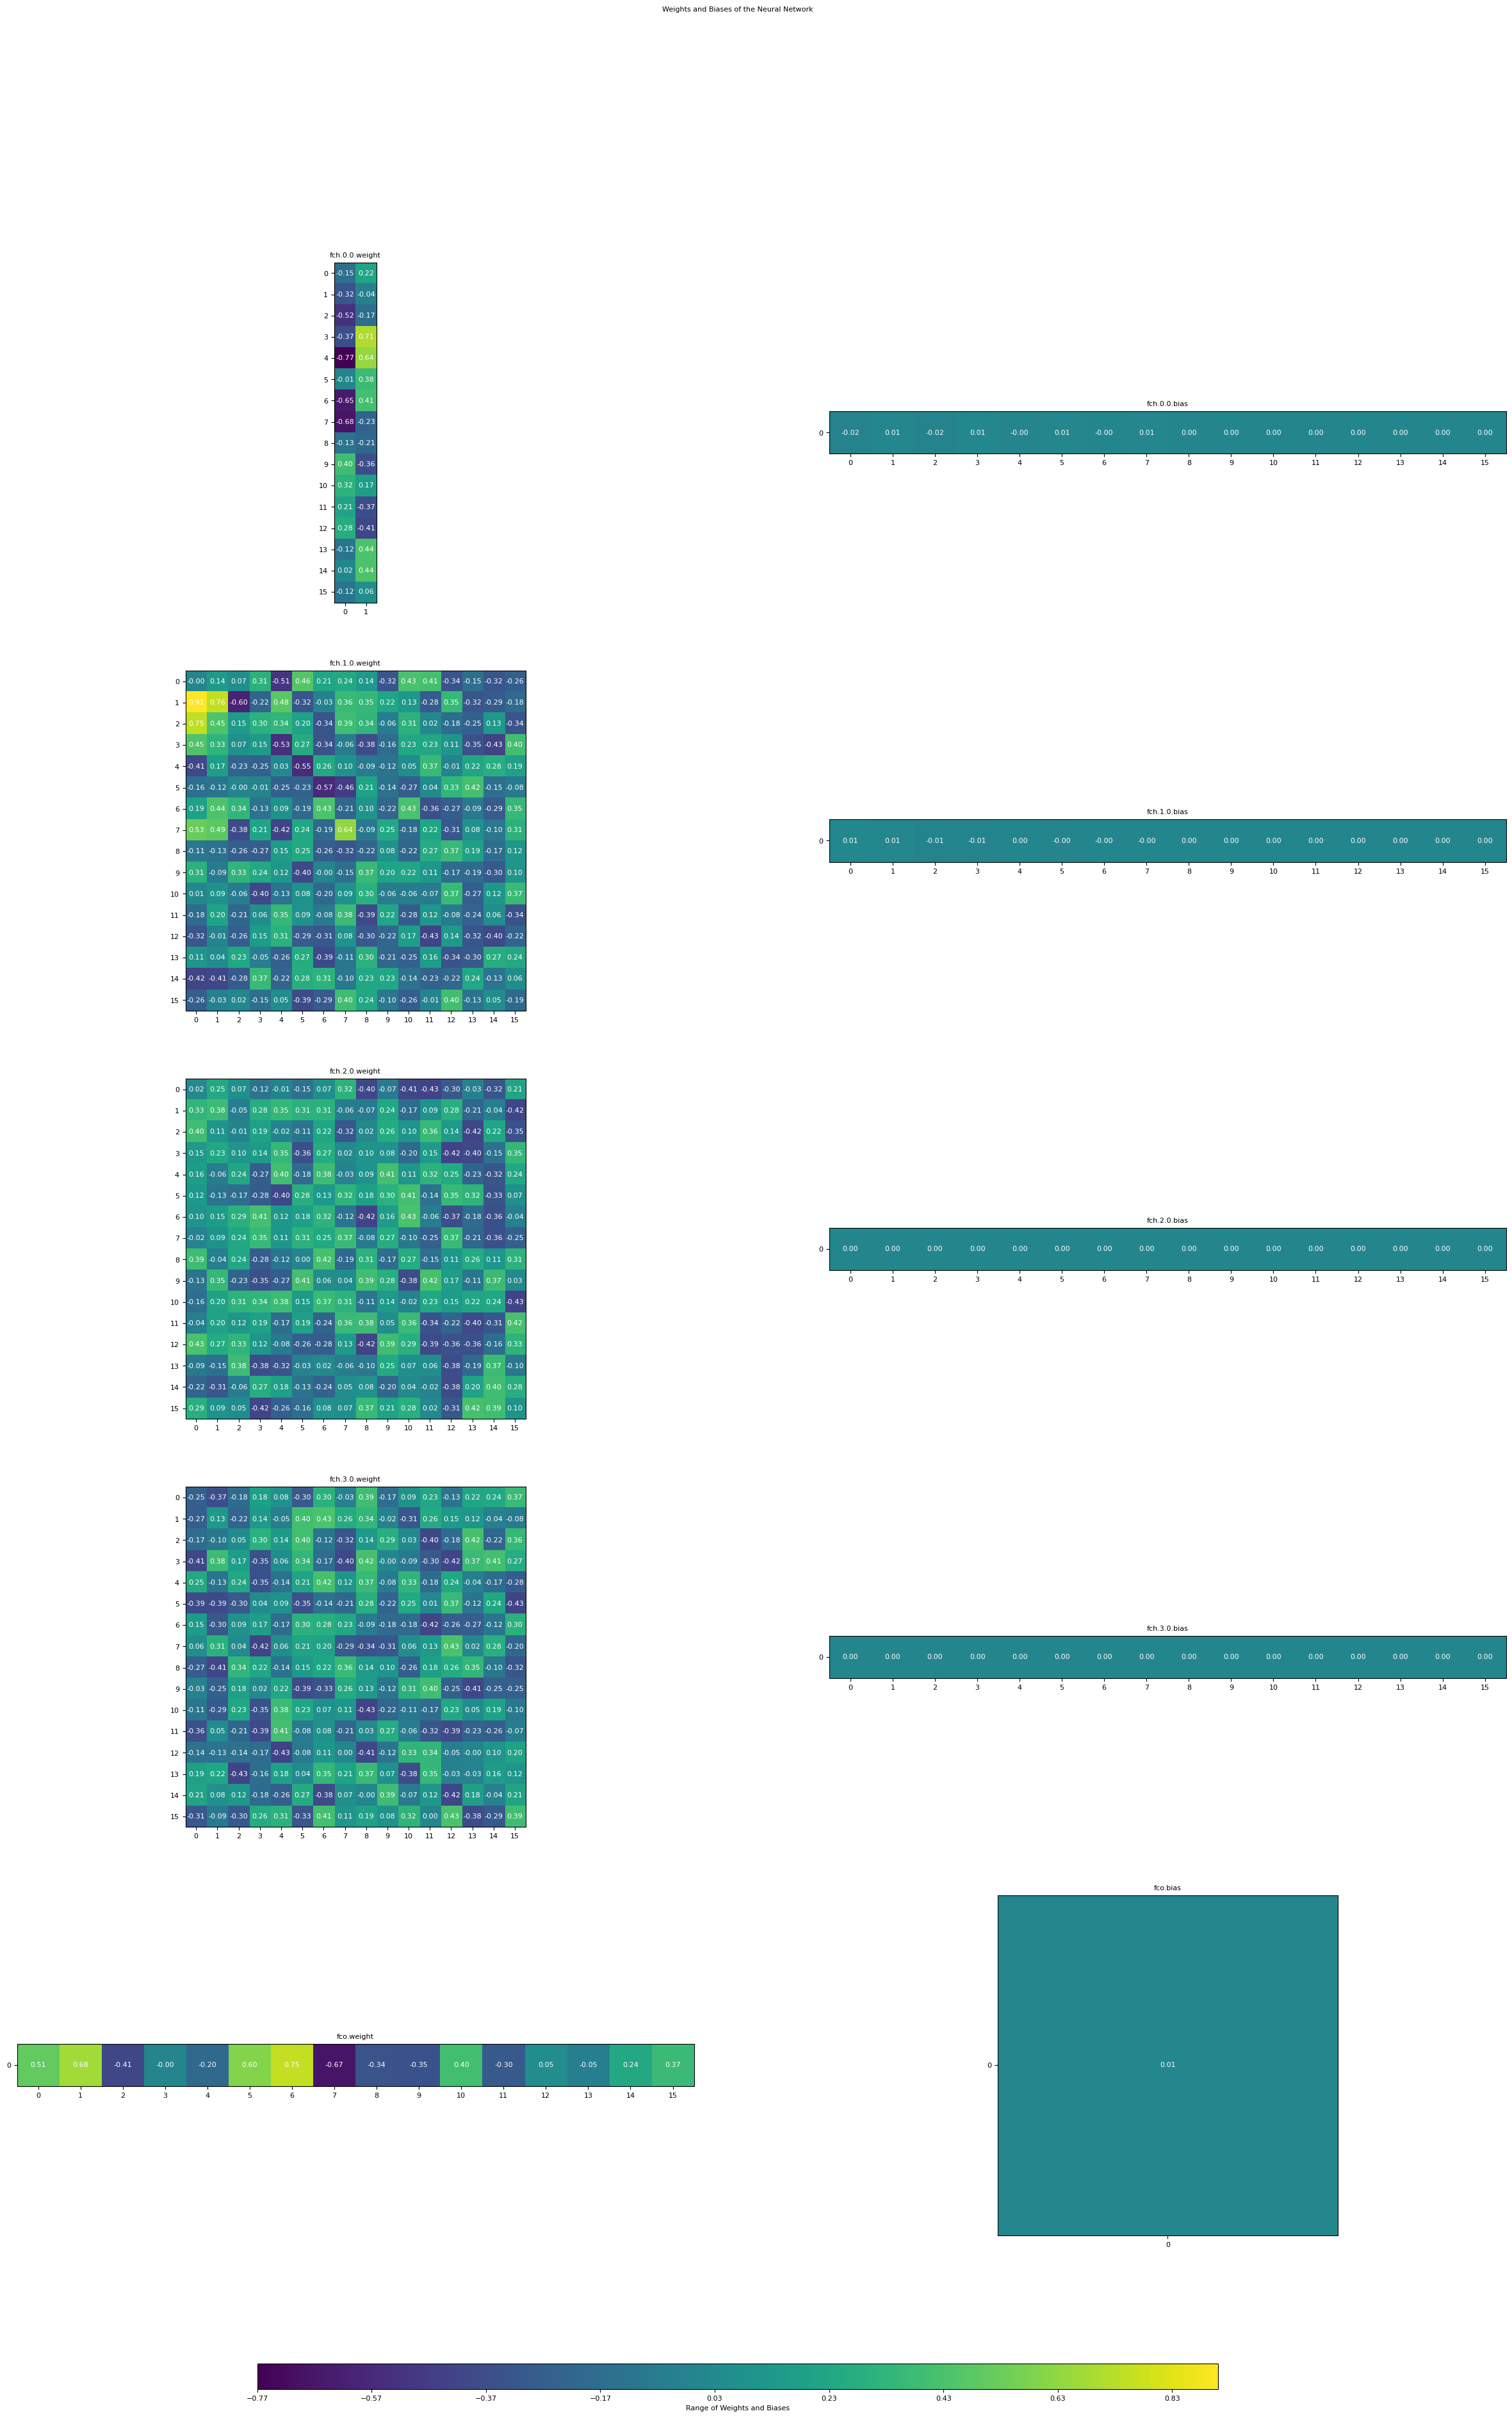

In [17]:
extended2_model.plot_weights(fig_size= (30,40), font_size = 8)